### Analysis of scRNA-seq of Etv2 reprogramming

In [132]:
library(SummarizedExperiment)
library(RColorBrewer)
library(dplyr)
library(parallel)
library(ggplot2)
library(goseq)
library(stringr)
library(TxDb.Mmusculus.UCSC.mm10.knownGene)
library(org.Mm.eg.db)
library(wordcloud)
library(plotrix)

Read the processed scRNA-seq data (~2.1G)
The scRNA-seq dataset was prepared in scRNA_seq_preprocess.Rmd

In [37]:
se <- readRDS(gzcon(url('https://s3.msi.umn.edu/garry_projects/etv2_pioneer/processed_Etv2_scRNAseq.rds')))

class: SummarizedExperiment 
dim: 17010 15475 
metadata(1): curves
assays(3): counts normalized_counts scaled_counts
rownames: NULL
rowData names(6): id name ... is_hvg clusters
colnames: NULL
colData names(7): barcodes group ... umap cluster

Determine the number of clusters by running k-means on the scVI latent space

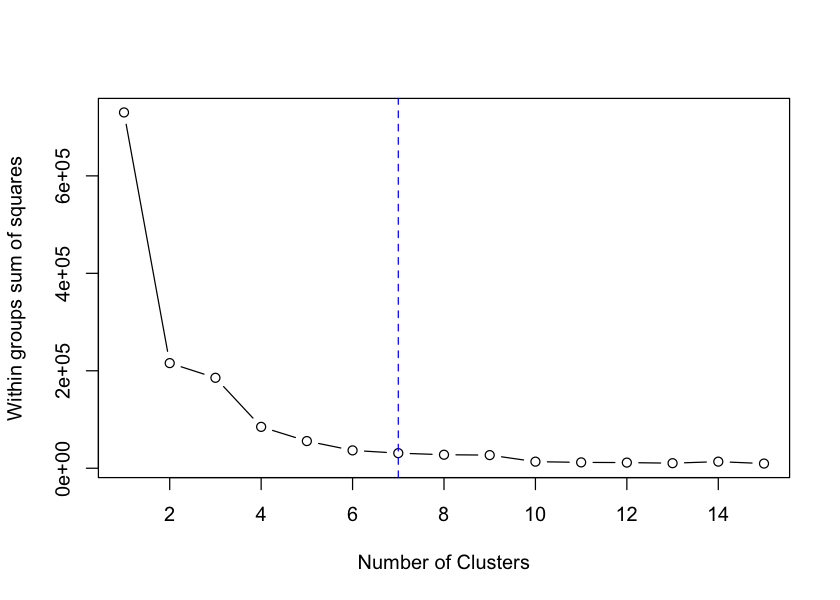

In [38]:
wss <- (nrow(colData(se)$umap)-1) * sum(apply(colData(se)$umap, 2, var))
for (i in 2:15) wss[i] <- sum(kmeans(colData(se)$umap,centers = i)$withinss)
options(repr.plot.width=7, repr.plot.height=5)
plot(1:15, wss, type="b", xlab="Number of Clusters", ylab="Within groups sum of squares")
n_cluster <- 7
abline(v = n_cluster, col = 'blue', lty = 2)

Visualize cell clusters

In [54]:
colData(se)$group <- colData(se)$group %>% factor(c('MEF_Dox_D1', 'MEF_NoDox', 'MEF_Dox_D2', 'MEF_Dox_D7a', 'MEF_Dox_D7b'))
se
set.seed(1)
# it is important to set nstart to a large number to get a relatively robust clustering result. 
cls <- kmeans(colData(se)$umap, n_cluster, nstart = 100)$cluster
table(cls, colData(se)$group)
cls <- as.numeric(factor(cls, c(4,5,3,2,1,7,6)))
table(cls, colData(se)$group)

class: SummarizedExperiment 
dim: 17010 15475 
metadata(1): curves
assays(3): counts normalized_counts scaled_counts
rownames: NULL
rowData names(6): id name ... is_hvg clusters
colnames: NULL
colData names(7): barcodes group ... umap cluster

   
cls MEF_Dox_D1 MEF_NoDox MEF_Dox_D2 MEF_Dox_D7a MEF_Dox_D7b
  1          1         0         17        1493           3
  2          0         6       1443           1           0
  3          0         4       1435          23           0
  4       2878       541         21           2           3
  5        657       381          1           0           0
  6          0         2          0           1         813
  7         26        14         19        5682           8

   
cls MEF_Dox_D1 MEF_NoDox MEF_Dox_D2 MEF_Dox_D7a MEF_Dox_D7b
  1       2878       541         21           2           3
  2        657       381          1           0           0
  3          0         4       1435          23           0
  4          0         6       1443           1           0
  5          1         0         17        1493           3
  6         26        14         19        5682           8
  7          0         2          0           1         813

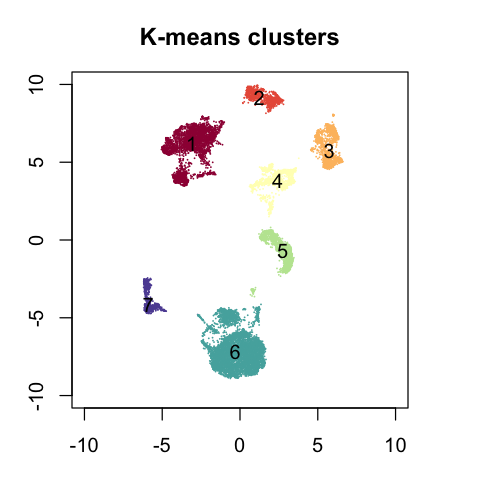

In [55]:
colData(se)$cluster <- cls
group2bg <- c(
   'MEF_Dox_D1' = 'black',
   'MEF_NoDox' = 'blue',
   'MEF_Dox_D2' = 'purple',
   'MEF_Dox_D7a' = 'red',
   'MEF_Dox_D7b' = 'pink'
 )
options(repr.plot.width=4, repr.plot.height=4)
par(mar = c(3, 3, 3, 3))
plot(
   colData(se)$umap,
   col = colorRampPalette(brewer.pal(11,'Spectral'))(n_cluster)[colData(se)$cluster],
   pch = 16, asp = 1, cex = 0.2,
   main = 'K-means clusters', xlab = '', ylab = '',
   xlim = c(-10, 10), ylim = c(-10, 10)
)
y_centers <- do.call('rbind', lapply(1:n_cluster, function(i) apply(colData(se)$umap[colData(se)$cluster == i, ], 2, median)))
text(y_centers[, 1], y_centers[, 2], 1:n_cluster, cex = 1)

Figure of cell sources (e.g. time points)

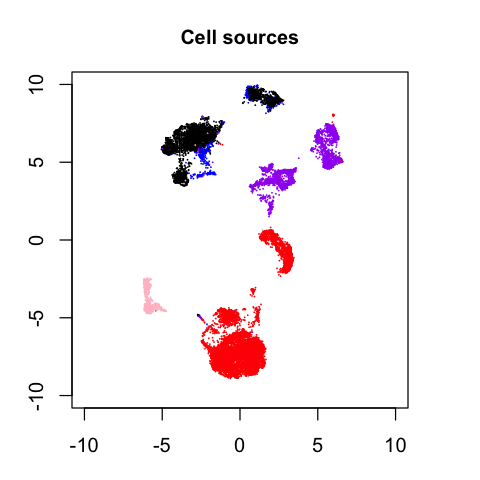

In [56]:
options(repr.plot.width=4, repr.plot.height=4)
par(mar = c(3, 3, 3, 3))
bg <- group2bg[colData(se)$group]
plot(colData(se)$umap, col = bg, asp = 1, pch = 16,  main = 'Cell sources', xlab = '', ylab = '', cex = 0.2, cex.main = 1, cex.axis = 1, xlim = c(-10, 10), ylim = c(-10, 10))

In [ ]:
Expresson plot of a set of genes

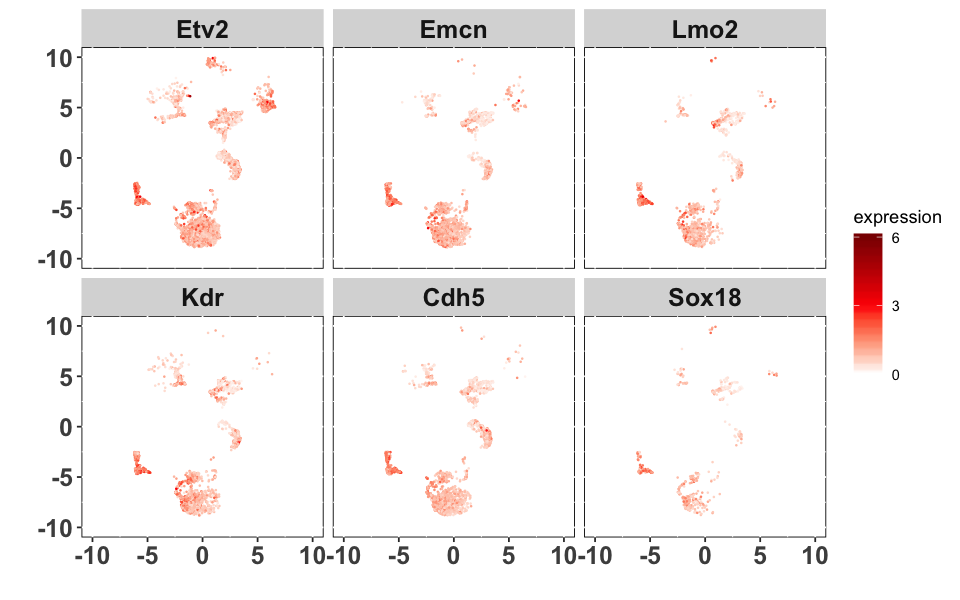

In [186]:
X <- assays(se)$normalized_counts
rownames(X) <- rowData(se)$name
gs <- c(
   'Etv2', 'Emcn', 'Lmo2', 'Kdr', 'Cdh5', 'Sox18'
)
d <- do.call('rbind', lapply(gs, function(g){
   x <- X[g, ]
   m <- which(x > 0.1)
   data.frame(gene = g, x = colData(se)$umap[m, 1], y = colData(se)$umap[m, 2], expression = x[m])
}))

b <- c(0, 3, 6)
options(repr.plot.width=8, repr.plot.height=5)
ggplot(d, aes(x = x, y = y, color = expression)) + geom_point(size = 0.25, shape = 20) +
   scale_color_gradientn(limits = c(0, max(b)), colours=c("white", "red", "darkred"), breaks=b, labels=format(b)) +
   theme(panel.background = element_rect(fill = 'white', colour = 'black')) +
   xlab('') + ylab('') +
   facet_wrap(~ gene, ncol = 3) +
   theme(strip.text.x = element_text(size = 15, face = 'bold')) +
   theme(axis.text = element_text(size = 15, face = 'bold')) +
   xlim(-10, 10) + ylim(-10, 10)

Identify the up-regulated genes in each cluster by using t-test on the scaled gene expression levels.
This step takes a few mins to finish.

In [61]:
X <- assays(se)$scaled_counts
clust <- colData(se)$cluster
h <- 7 # Flk1+ cell cluster
pvalues <- mclapply(
  1:nrow(X), function(i) wilcox.test(X[i, clust == h], X[i, clust != h], alternative = 'greater')$p.value,
  mc.cores = 4) %>% unlist()
head(pvalues)

[1] 1.000000000 0.999999669 0.760553860 1.000000000 0.997500270 0.002978139

Pathway analysis of highly expressed genes in each cluster
Create a list of signifiant genes up-regulated in each cluster, fit the Probability Weighting Function (PWF) and find the significantly enriched GO terms.

In [76]:
genes <- as.integer(pvalues < 1e-10)
names(genes) <- rowData(se)$name
genes <- genes[!duplicated(names(genes))]
pwf <- nullp(genes, "mm10", "geneSymbol", plot.fit = FALSE)
go_res <- goseq(pwf, "mm10","geneSymbol", test.cats = c("GO:BP"))

Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotation package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Fetching GO annotations...
For 2232 genes, we could not find any categories. These genes will be excluded.
To force their use, please run with use_genes_without_cat=TRUE (see documentation).
This was the default behavior for version 1.15.1 and earlier.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


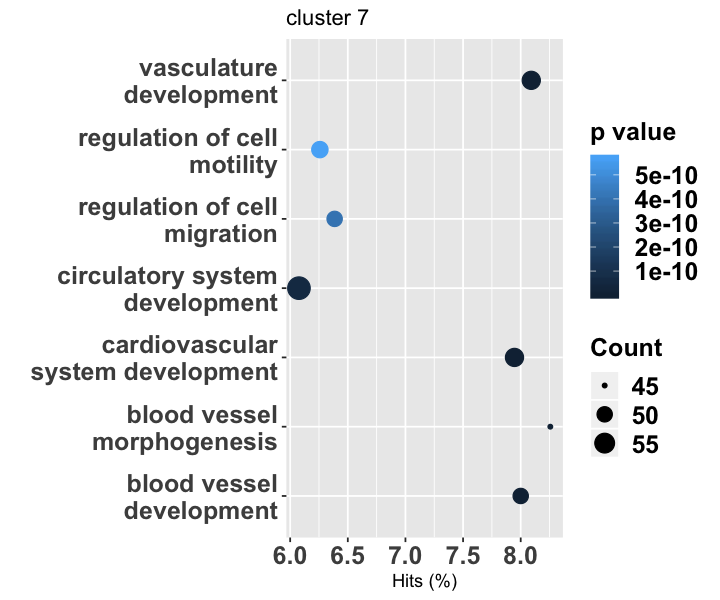

In [74]:
options(repr.plot.width=6, repr.plot.height=5)
go_res %>%
   filter(numInCat < 1000) %>%
   top_n(7, wt = -over_represented_pvalue) %>%
   mutate(hitsPerc = numDEInCat * 100 / numInCat, term = str_wrap(term, 20)) %>%
   ggplot(aes(x = hitsPerc, y = term, colour = over_represented_pvalue, size = numDEInCat)) +
   geom_point() +
   labs(title = sprintf('cluster %d', h), x="Hits (%)", y="", colour="p value", size="Count") +
   theme(axis.text = element_text(size = 15, face = 'bold')) +
   theme(legend.text = element_text(size = 15, face = 'bold')) +
   theme(legend.title = element_text(size = 15, face = 'bold'))

Identify the up- and down- regulated genes between cluster 1 (MEF) and cluster 7 (Flk1by using t-test on the scaled gene expression levels.
This step takes a few mins to finish.

In [81]:
is_cls7 <- clust == 7
is_cls1 <- clust == 1
pvalues_71 <- mclapply(
  1:nrow(X), function(i) wilcox.test(X[i, is_cls7], X[i, is_cls1], alternative = 'two.sided')$p.value,
  mc.cores = 4) %>% unlist()
fc_71 <- rowMeans(X[, is_cls7]) - rowMeans(X[, is_cls1])
names(pvalues_71) <- names(fc_71) <- rowData(se)$name

Generate a vocano plot for differentially expressed genes between MEF and Flk1+ cells at D7
* Cd44 is a hematopoietic marker.  It looks like Etv2 inhibit the expression of Cd44. We also see this in the EB Etv2 induction data. 

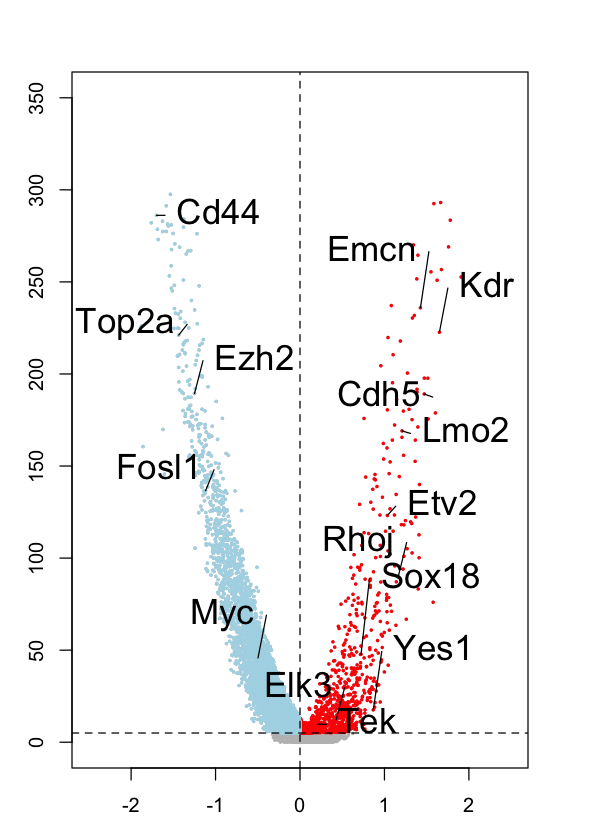

In [191]:
options(repr.plot.width=5, repr.plot.height=7)
par(mar = c(3, 3, 3, 3))
par(xpd = FALSE)
plot(fc_71, -log10(pvalues_71), pch = 21, bg = 'gray', col = 'gray', cex = 0.25, xlim = c(-2.5, 2.5), ylim = c(0, 350))
is_up <- pvalues_71 < 1e-5 & fc_71 > 0
points(fc_71[is_up], -log10(pvalues_71[is_up]), pch = 21, bg = 'red', col = 'red', cex = 0.25)
is_down <- pvalues_71 < 1e-5 & fc_71 < 0
points(fc_71[is_down], -log10(pvalues_71[is_down]), pch = 21, bg = 'lightblue', col = 'lightblue', cex = 0.25)
abline(h = 5, v = 0, lty = 2, col = 'black')
up <- c('Etv2', 'Kdr', 'Emcn', 'Lmo2', 'Cdh5', 'Sox18', 'Tek', 'Elk3', 'Rhoj', 'Yes1')
down <- c('Cd44', 'Myc', 'Fosl1', 'Top2a', 'Ezh2')
gs <- c(up, down)
spread.labels(fc_71[gs], -log10(pvalues_71[gs]), gs, offsets = 0.1, between = FALSE, cex = 1.75)


In [197]:
df <- data.frame(name = rowData(se)$name, fc = fc_71, pvalue = pvalues_71)
df <- df[!is.na(df$pvalue), ]
df[order(df$pvalue), ]

,name,fc,pvalue
165,Col3a1,1.985061,0.000000e+00
2457,Hprt,1.754761,0.000000e+00
3672,Ddah1,-1.747757,0.000000e+00
4251,Ybx1,-1.278268,0.000000e+00
5912,Ptn,1.874753,0.000000e+00
7867,Ifitm2,2.095723,0.000000e+00
7869,Ifitm3,1.749811,0.000000e+00
8667,Hmga2,-1.807456,0.000000e+00
9122,Uba52,1.808543,0.000000e+00
10232,Itm2b,2.043730,0.000000e+00


In [75]:
sessionInfo()

R version 3.6.2 (2019-12-12)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Catalina 10.15.2

Matrix products: default
BLAS/LAPACK: /Users/gongx030/anaconda3/envs/r/lib/libopenblasp-r0.3.7.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] org.Mm.eg.db_3.10.0                      
 [2] TxDb.Mmusculus.UCSC.mm10.knownGene_3.10.0
 [3] GenomicFeatures_1.38.1                   
 [4] AnnotationDbi_1.48.0                     
 [5] rtracklayer_1.46.0                       
 [6] stringr_1.4.0                            
 [7] goseq_1.38.0                             
 [8] geneLenDataBase_1.22.0                   
 [9] BiasedUrn_1.07                           
[10] ggplot2_3.2.1                            
[11] dplyr_0.8.4                              
[12] RColorBrewer_1.1-2                      